In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('../'))

In [2]:
import torch

In [3]:
import torchvision.models as models
from torch import load
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np
from ModelDefs.models import ModelFactory
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24

plt.rcParams['xtick.labelsize'] = 24 
plt.rcParams['ytick.labelsize'] = 24  

attack1='FGSM'
attack2 = 'PGD'
reps = 3

In [46]:
from foolbox.attacks import LinfPGD, L2PGD, L1BrendelBethgeAttack, SaltAndPepperNoiseAttack, L2AdditiveGaussianNoiseAttack, LinfAdditiveUniformNoiseAttack
from foolbox.attacks import NewtonFoolAttack, LinfDeepFoolAttack

In [5]:
from DataDefs.data import get_data
train_loader, test_loader, full_loader = get_data(dataset='CIFAR10', batch_size=10_000, _seed=0,
                                                  validate=False, data_dir='../data/')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# X_full, _ = next(iter(full_loader))
X_test, Y_test = next(iter(test_loader))

In [7]:
X_test = X_test.cuda()
Y_test = Y_test.cuda();

In [8]:
vgg11loader_ft = load("vgg11_no_aug_fine_tune");
cfgs = vgg11loader_ft[0][0]

model_reg = ModelFactory(**cfgs).eval()
model_reg.load_state_dict(vgg11loader_ft[0][1])
fmodel_reg = PyTorchModel(model_reg, bounds=(X_test.min(), X_test.max()) )


vgg11loader = load("vgg11_no_aug");
cfgs = vgg11loader[0][0]

model = ModelFactory(**cfgs).eval()
model.load_state_dict(vgg11loader[0][1])
fmodel = PyTorchModel(model, bounds=(X_test.min(), X_test.max()) )

In [54]:
attack = LinfPGD(steps=40)

sigmas = np.linspace(0,5,100).tolist()

In [55]:
bs = 20
nbatch = X_test.shape[0]/bs

susbs = 5

noise_attack_reg = np.zeros((susbs+1, len(sigmas))).T
noise_attack = np.zeros((susbs+1, len(sigmas))).T
for i in range(susbs+1):
    images, labels = ep.astensors(X_test[bs*i:bs*(i+1),...],Y_test[bs*i:bs*(i+1)])
    _, _, success = attack(fmodel, images, labels, epsilons= sigmas )
    noise_attack[:,i] = (1- success.astype(torch.float).mean(axis=1).raw.cpu().numpy())*100
    
    _, _, success = attack(fmodel_reg, images, labels, epsilons= sigmas )
    noise_attack_reg[:,i] = (1- success.astype(torch.float).mean(axis=1).raw.cpu().numpy())*100

80.83333333333333
8.858454843945541


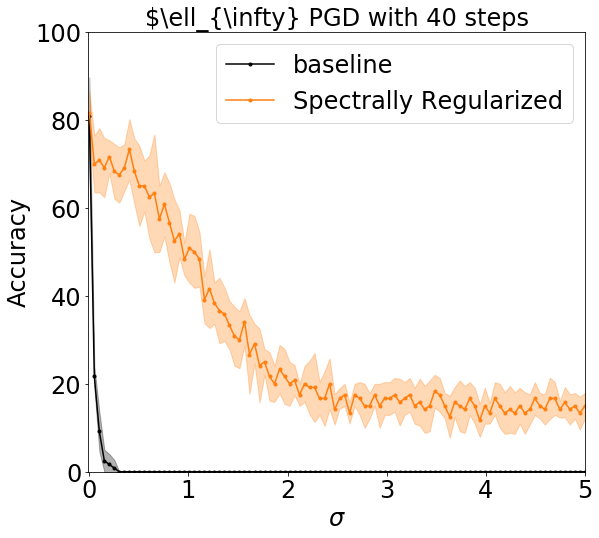

In [56]:
avg_regular_noisy = np.mean(noise_attack, 1)
std_regular_noisy = np.std(noise_attack, 1)

avg_regular_noisy_reg = np.mean(noise_attack_reg, 1)
std_regular_noisy_reg = np.std(noise_attack_reg, 1)


print(avg_regular_noisy[0])
print(std_regular_noisy[0])
ylim = [-0.01, 100.1]
fig = plt.figure(figsize=(16, 8))
"Noisy"
ax = fig.add_subplot(121)
ax.set_title(r'$\ell_{\infty} PGD with 40 steps')
ax.plot(np.array(sigmas), avg_regular_noisy, marker='.', color='k', label='baseline')
ax.fill_between(sigmas, avg_regular_noisy - std_regular_noisy,
                avg_regular_noisy + std_regular_noisy, alpha='0.3',color='black')

ax.plot(np.array(sigmas), avg_regular_noisy_reg, marker='.', color='tab:orange', label='Spectrally Regularized')
ax.fill_between(sigmas, avg_regular_noisy_reg - std_regular_noisy_reg,
                avg_regular_noisy_reg + std_regular_noisy_reg, alpha='0.3',color='tab:orange')


xlim = ax.get_xlim()
ax.set_xlim([-0.01, sigmas[-1]])


ax.set_ylim(ylim)
ax.set_ylabel('Accuracy')
ax.set_xlabel(r'$\sigma$')
ax.legend()
fig.tight_layout()
fig.savefig('linfPGD40Steps.pdf', dpi=300)

Noisy robustness